In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Activation, GlobalMaxPool2D
from keras.optimizers import SGD
import time
import datetime

%matplotlib inline
np.set_printoptions(linewidth=120)
plt.rcParams['figure.figsize'] = (19, 13)

Using TensorFlow backend.


# Step 2a Load Trained Model

We can now make use of the trained model to make predictions. Let's load that and the data as well

In [2]:
# read in data and store in RAM
path = 'D:/Projects/eh17_NAM/Machine_Learning/AAA_QC/numpy_data/'
tmp = np.load(path + 'RevXII_RawData.npz')

X_all = tmp['X_raw_all']
print(X_all.shape)

Y_all = tmp['Y_all']
print(Y_all.shape)

shot_id = tmp['shot_id']
print(shot_id.shape)

print(4*np.product(X_all[0].shape)/1024/1024, 'MB per shot')

# compute weights to normalize class imbalance
W_all = np.zeros_like(Y_all).astype(np.int)
W_all[Y_all == 0] = 3
W_all += 1

(1042, 621, 512, 3)
(1042,)
(1042,)
3.638671875 MB per shot


In [3]:
# stitch layers to the VGG16 layers
orig_VGG16 = VGG16(weights='imagenet', include_top=False)

num_filters = 64
dropout_prob = 0.55
x = orig_VGG16.get_layer('block2_pool').output
x = Conv2D(num_filters, (1, 1), activation='relu', padding='same', name='block6_conv1')(x)
x = GlobalMaxPool2D(name='block6_pool')(x)
x = Dropout(dropout_prob)(x)

x = Dense(num_filters)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_prob)(x)

prediction = Dense(1, activation='sigmoid')(x)
model_A = Model(inputs=orig_VGG16.input, outputs=prediction)

# load previously saved weights
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
file_name = 'model_weights/20170816_13_33.h5'
model_A.load_weights(path + file_name)
print('Loaded ConvNet weights: ' + path + file_name)

Loaded ConvNet weights: //hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/model_weights/20170816_13_33.h5


Validate that it is a good model, it should give us a high AUROC score

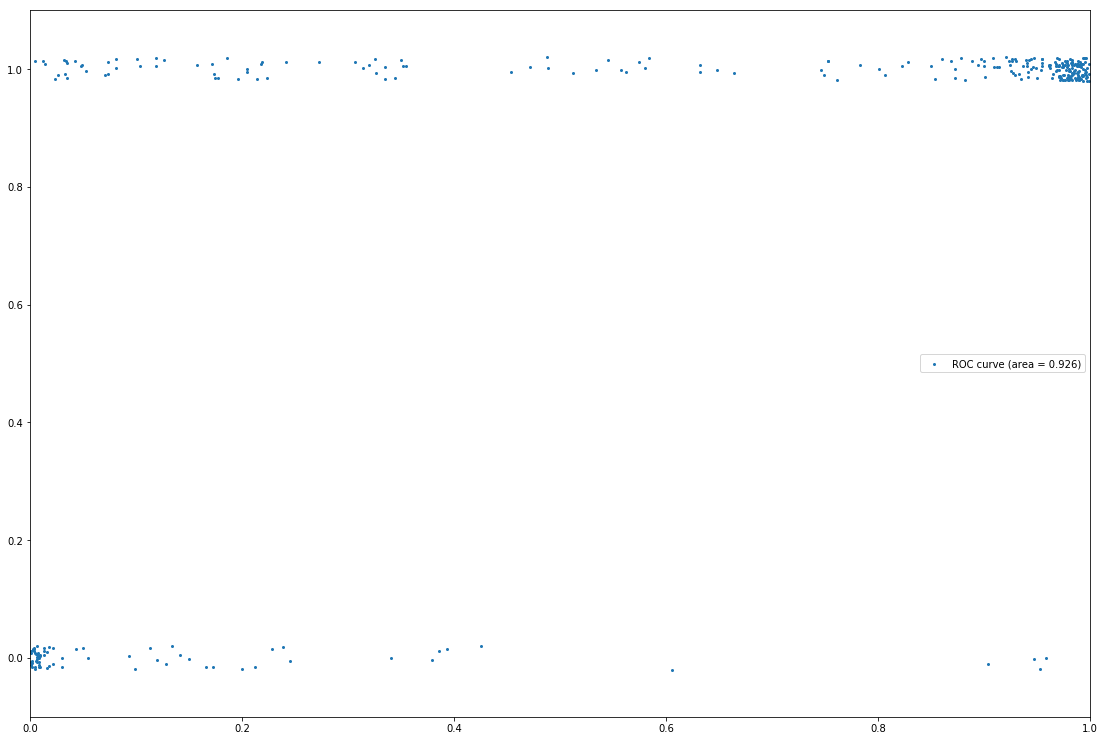

In [4]:
Y_predict = model_A.predict(X_all[-313:])
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict)
plt.scatter(Y_predict, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

I have another model that I trained earlier, let's load that in as well

In [5]:
# stitch layers to the VGG16 layers
orig_VGG16 = VGG16(weights='imagenet', include_top=False)

num_filters = 64
dropout_prob = 0.55
x = orig_VGG16.get_layer('block2_pool').output
x = Conv2D(num_filters, (1, 1), activation='relu', padding='same', name='block6_conv1')(x)
x = GlobalMaxPool2D(name='block6_pool')(x)
x = Dropout(dropout_prob)(x)

x = Dense(num_filters)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_prob)(x)

prediction = Dense(1, activation='sigmoid')(x)
model_B = Model(inputs=orig_VGG16.input, outputs=prediction)

# load previously saved weights
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
file_name = 'model_weights/20170624_14_49.h5'
model_B.load_weights(path + file_name)
print('Loaded ConvNet weights: ' + path + file_name)

Loaded ConvNet weights: //hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/model_weights/20170624_14_49.h5


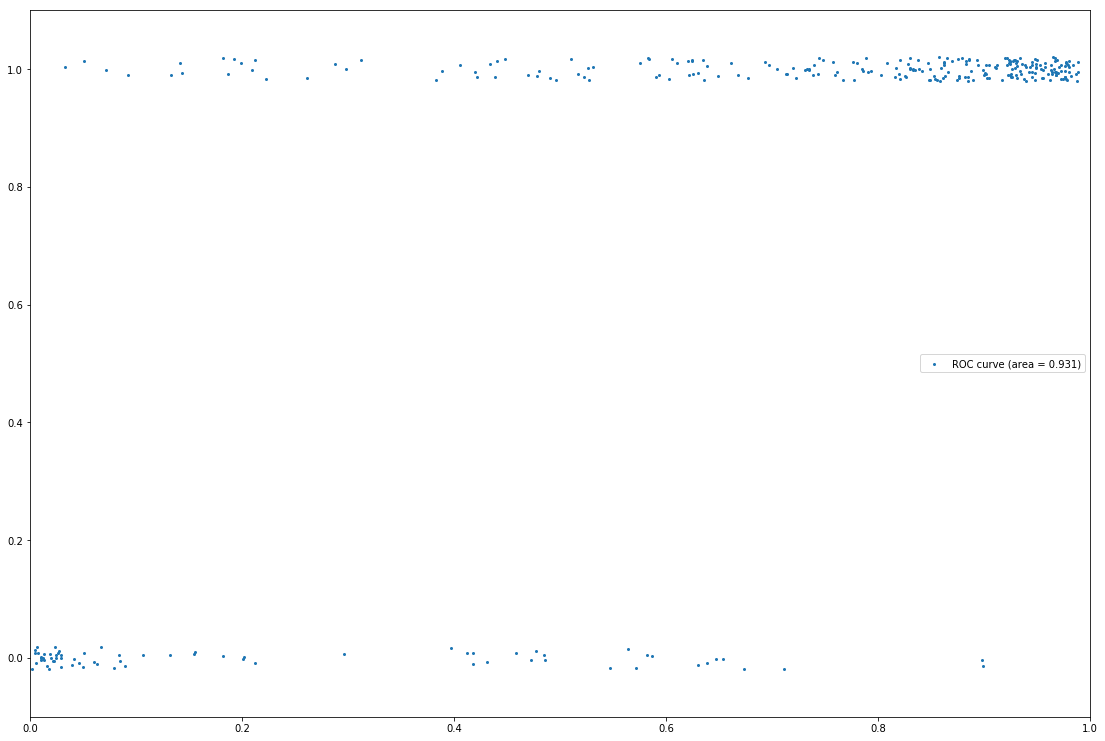

In [6]:
Y_predict = model_B.predict(X_all[-313:])
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict)
plt.scatter(Y_predict, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

# Step 2b Analyze Mispredicted Shots

Let's identify the shots that were wrongly predicted

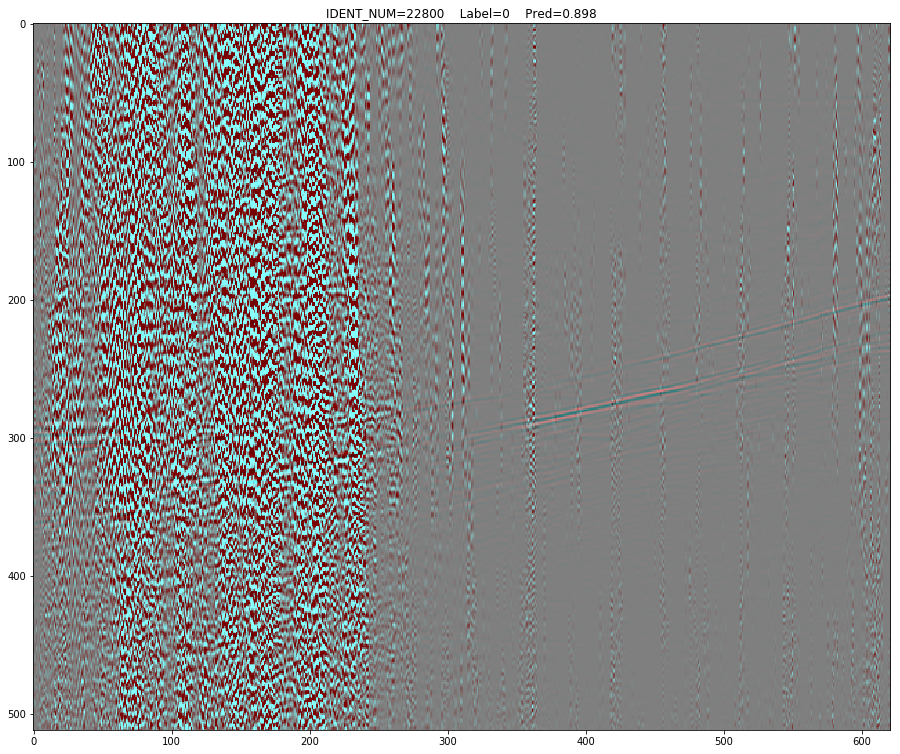

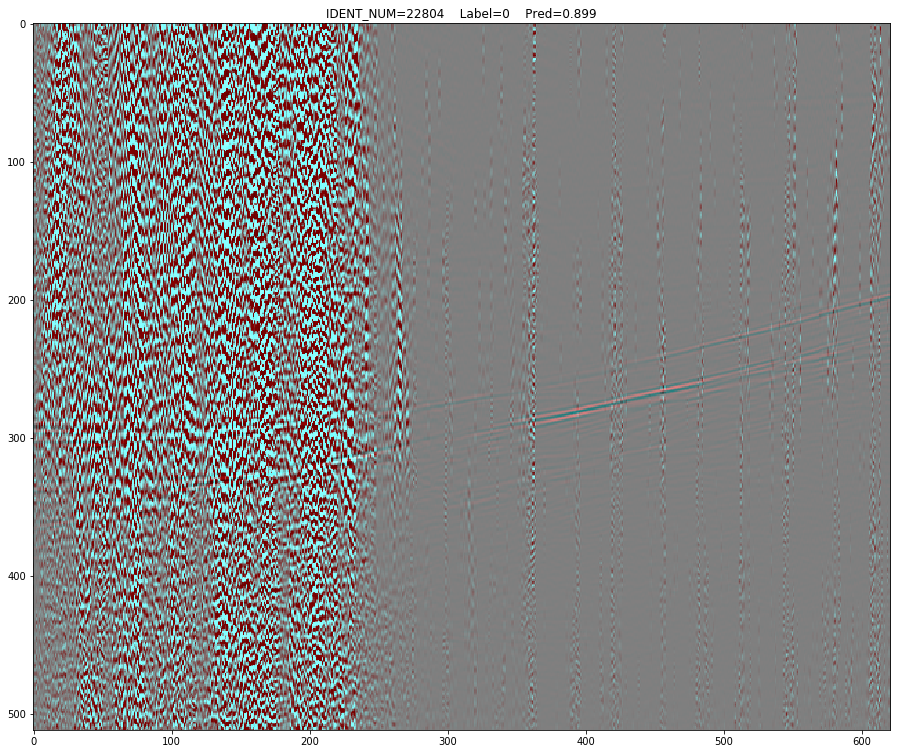

In [7]:
Y_validation = Y_all[729:]
shot_id_validation = shot_id[729:]

# identify false negatives
for i in range(Y_predict.shape[0]):
    if ((2*Y_validation[i] - 1) * (2*Y_predict[i] - 1) < -0.6) and Y_validation[i] == 0:
        plt.imshow(np.transpose(X_all[i], axes=(1, 0, 2)).astype(np.uint8), origin='upper')
        plt.title('IDENT_NUM=%d    Label=%d    Pred=%0.3f' % (shot_id_validation[i], Y_validation[i], Y_predict[i]))
        plt.show()

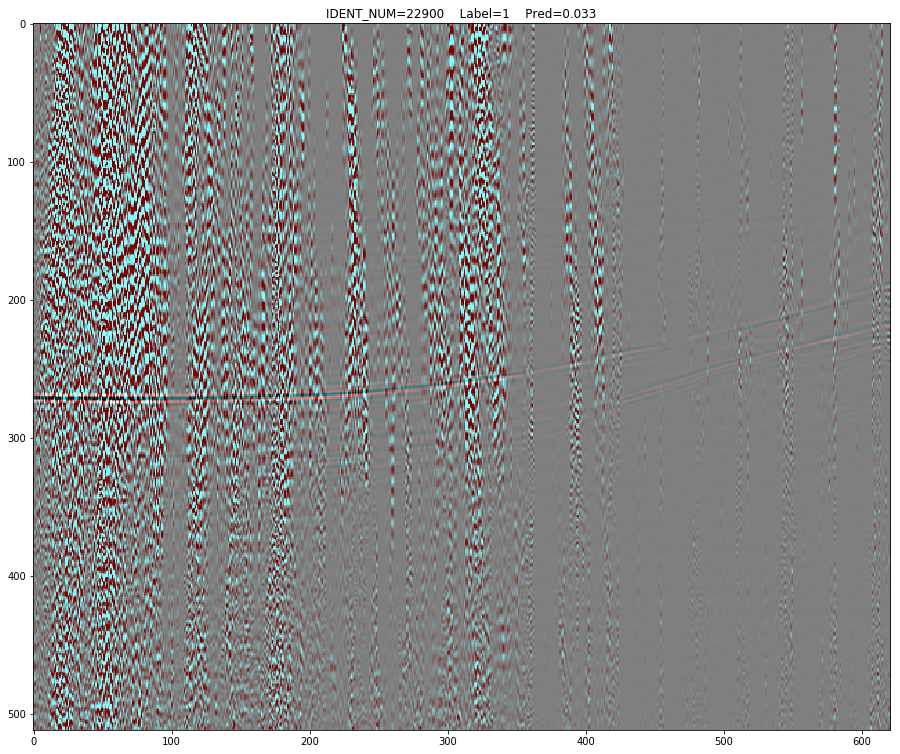

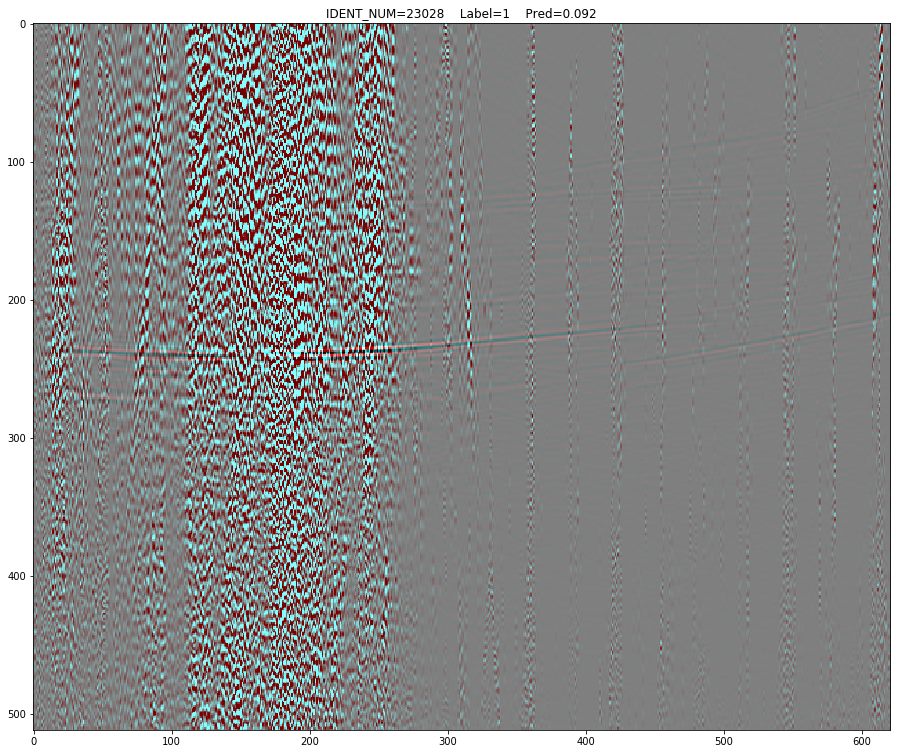

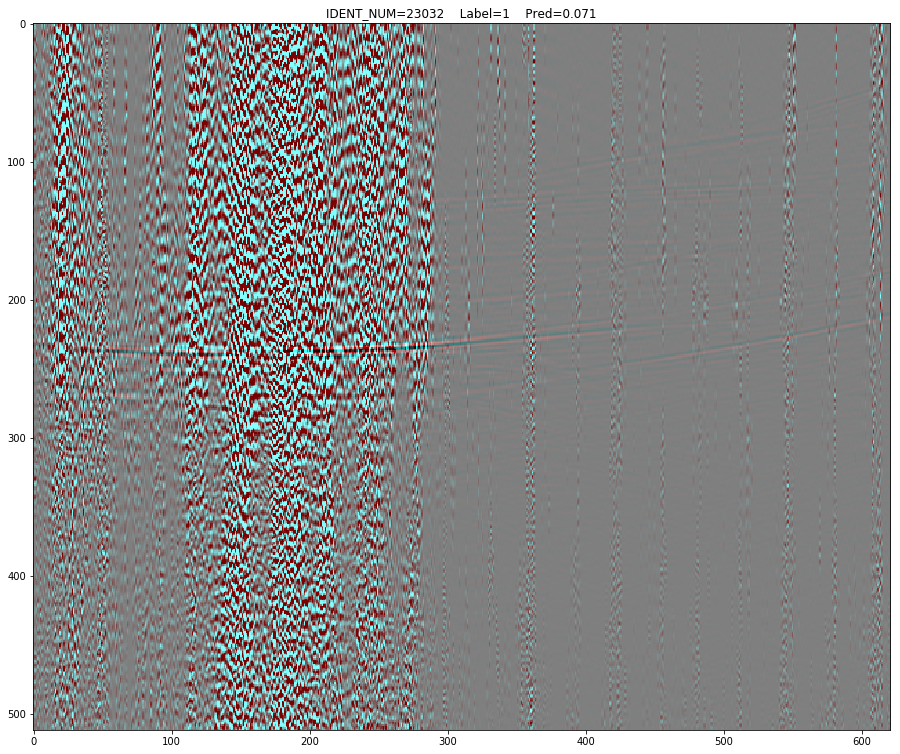

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
Y_validation = Y_all[729:]
shot_id_validation = shot_id[729:]

# identify false positives
for i in range(Y_predict.shape[0]):
    if ((2*Y_validation[i] - 1) * (2*Y_predict[i] - 1) < -0.7) and Y_validation[i] == 1:
        plt.imshow(np.transpose(X_all[i], axes=(1, 0, 2)).astype(np.uint8), origin='upper')
        plt.title('IDENT_NUM=%d    Label=%d    Pred=%0.3f' % (shot_id_validation[i], Y_validation[i], Y_predict[i]))
        plt.show()

# Step 2c Saliency Analysis aka Occlusion Analysis

A trained model will give us a prediction every time we input a shot to it but can it explain to us why it accepted or rejected that shot?

It can't explain like a human would but we can get closer towards that. Here we will present a common technique called saliency analysis.

In [14]:
def occlude_shot(shot, x, y, size):
    output = np.copy(shot)
    output[x:x+size, y:y+size, :] = 127.5
    return output


def occlusion_heatmap(shot, predictor, size):
    xrange = np.arange(0, shot.shape[0], size // 2)
    yrange = np.arange(0, shot.shape[1], size // 2)

    heatmap_output = np.empty((len(xrange), len(yrange)), dtype=float)

    i = 0
    for x in xrange:
        j = 0
        for y in yrange:
            output = occlude_shot(np.copy(shot), x, y, size)
            heatmap_output[i, j] = predictor.predict(np.expand_dims(output, axis=0))[0, 0]
            j += 1
        i += 1

    return heatmap_output

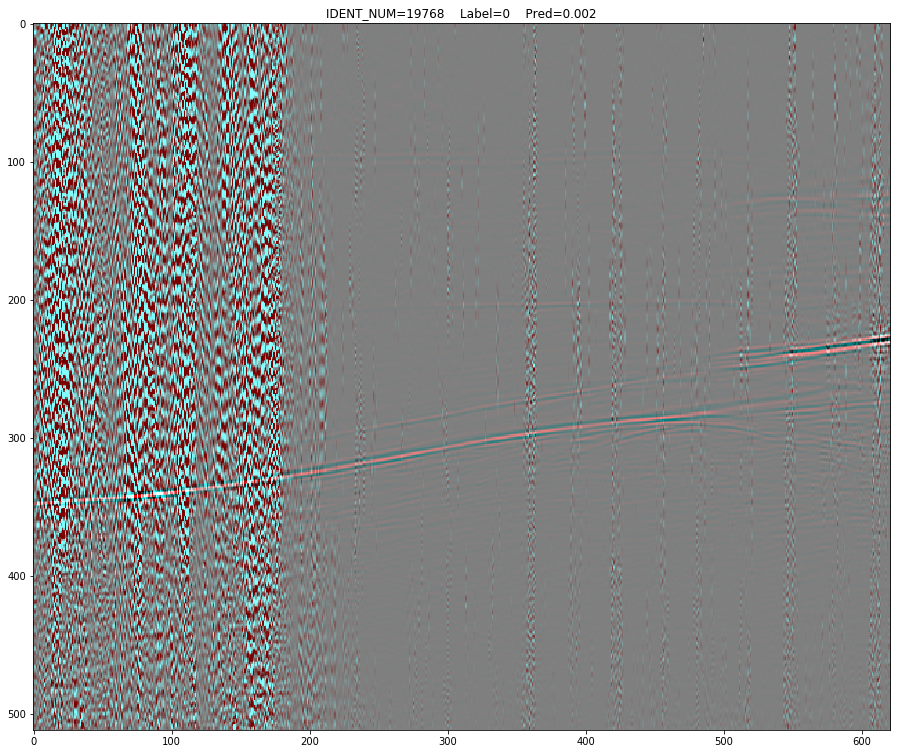

In [27]:
shot_num = 48
occluded = X_all[shot_num]
plt.imshow(np.transpose(occluded, axes=(1, 0, 2)).astype(np.uint8), origin='upper');
plt.title('IDENT_NUM=%d    Label=%d    Pred=%0.3f' % (shot_id[shot_num], Y_all[shot_num], model_B.predict(np.expand_dims(occluded, axis=0))));

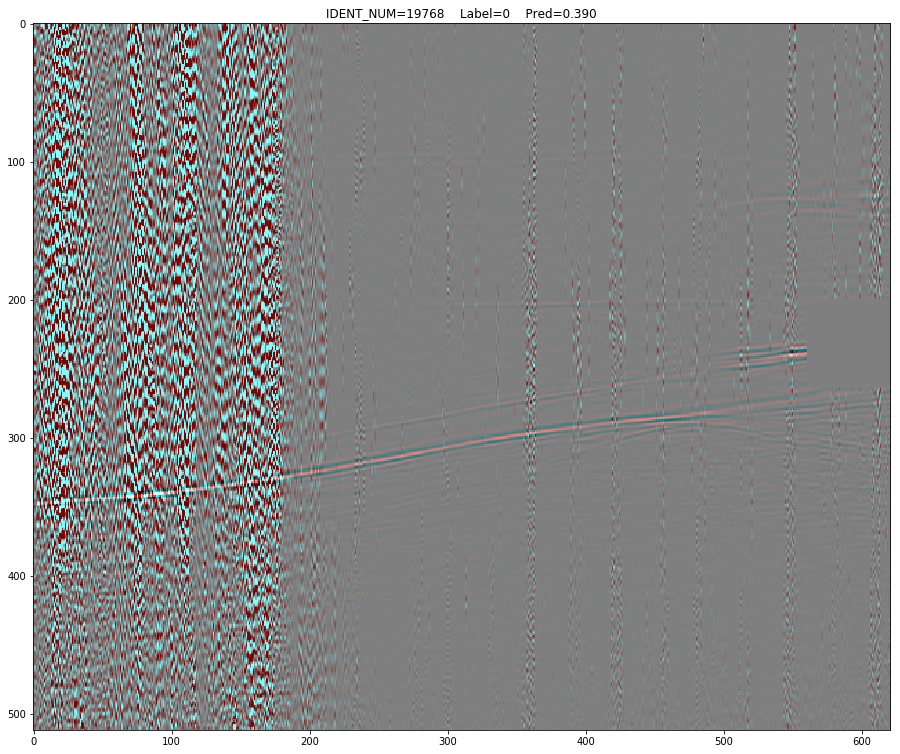

In [28]:
shot_num = 48
occluded = occlude_shot(X_all[shot_num], 560, 200, 64)
plt.imshow(np.transpose(occluded, axes=(1, 0, 2)).astype(np.uint8), origin='upper');
plt.title('IDENT_NUM=%d    Label=%d    Pred=%0.3f' % (shot_id[shot_num], Y_all[shot_num], model_B.predict(np.expand_dims(occluded, axis=0))));

One thing we can do is occlude the image a regular grids and see how the predictions change each time. That way we can plot at "heatmap" to see which areas are meaningful for the ConvNet.

Here we apply it to a false positive we saw earlier. This will allow us to answer the question "Where did my ConvNet think it saw signal leakage on this shot?"

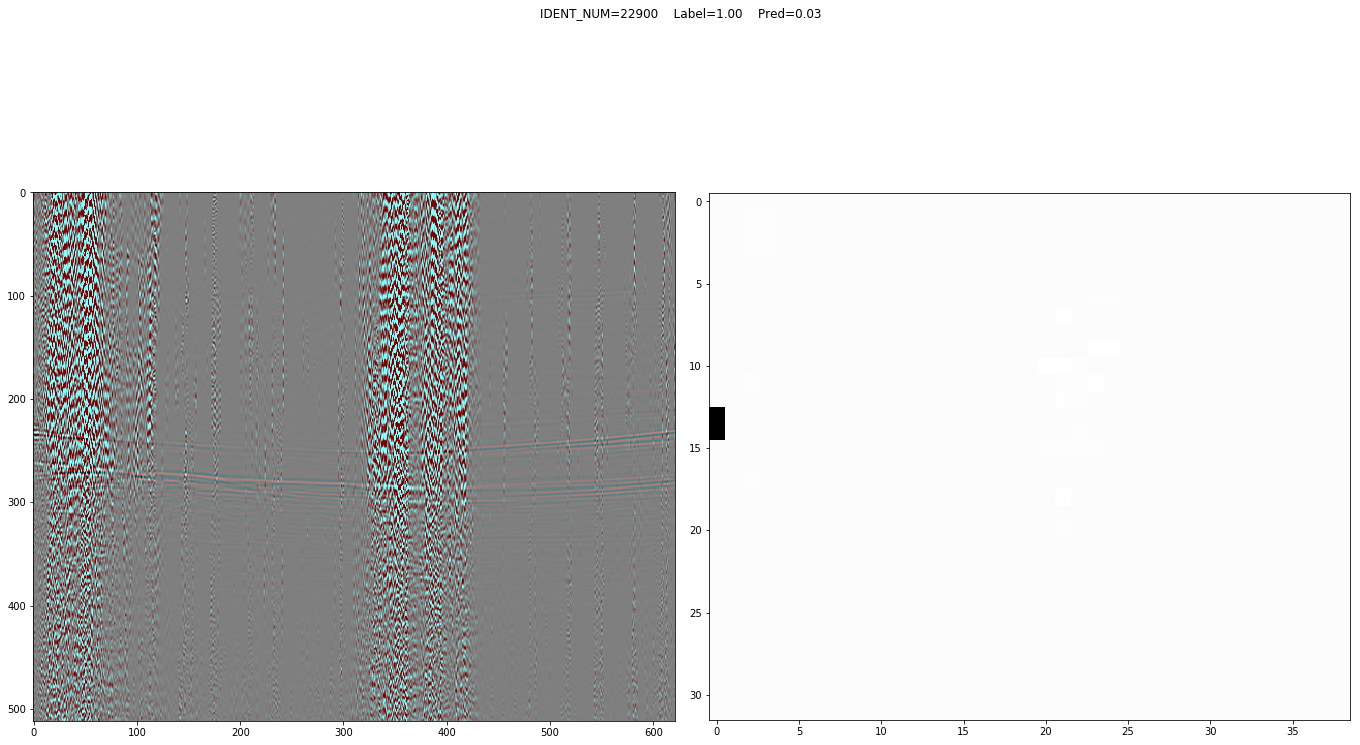

In [36]:
shot_num = 829
heatmap = occlusion_heatmap(X_all[shot_num], model_B, 32)
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(X_all[shot_num], axes=(1, 0, 2)).astype(np.uint8), origin='upper')
plt.suptitle('IDENT_NUM=%d    Label=%0.2f    Pred=%0.2f' % (shot_id[shot_num], Y_all[shot_num], model_B.predict(np.expand_dims(X_all[shot_num], axis=0))))
plt.subplot(1, 2, 2)
plt.imshow(heatmap.T, cmap='Greys', origin='upper', interpolation='nearest')
plt.tight_layout()

We can clearly see where the ConvNet "detected" signal leakage!

BTW this method would not work so well on false negatives. Can you think of why?

# Step 2d Model Ensembling

We have two models so we can output two sets of predictions for the gathers we have. Let's see if they are quite different.

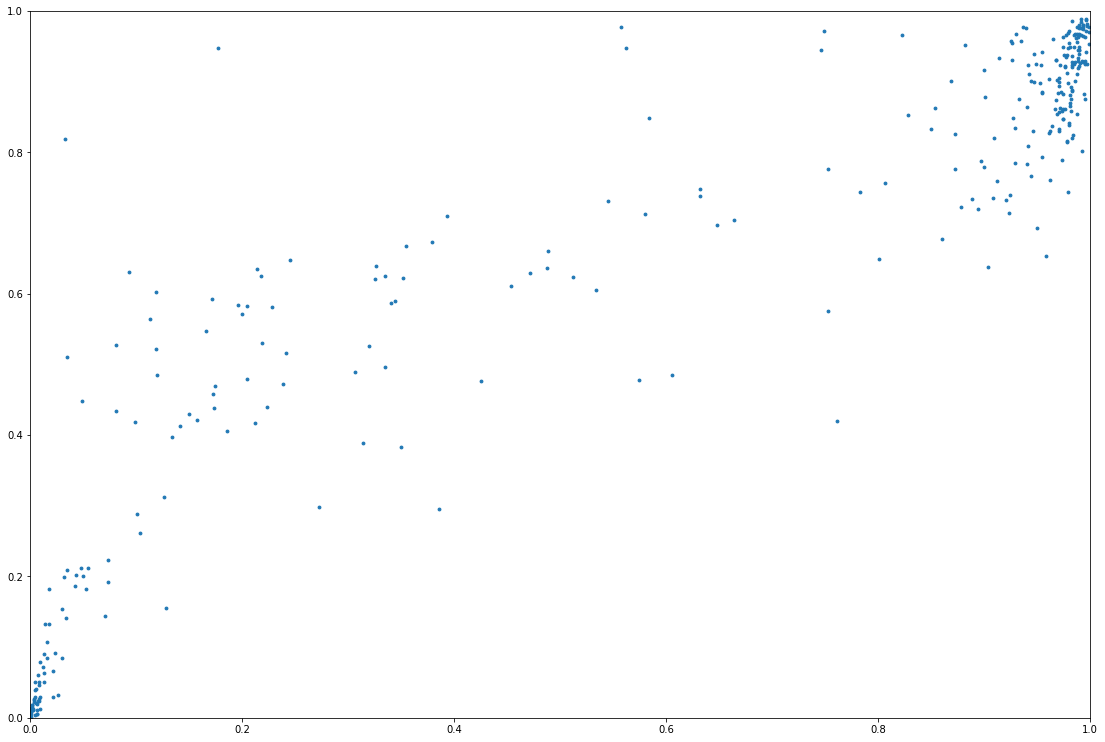

In [23]:
Y_predict_A = model_A.predict(X_all[-313:])
Y_predict_B = model_B.predict(X_all[-313:])

plt.scatter(Y_predict_A, Y_predict_B, s=8, label='Prediction Correlation');
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0]);

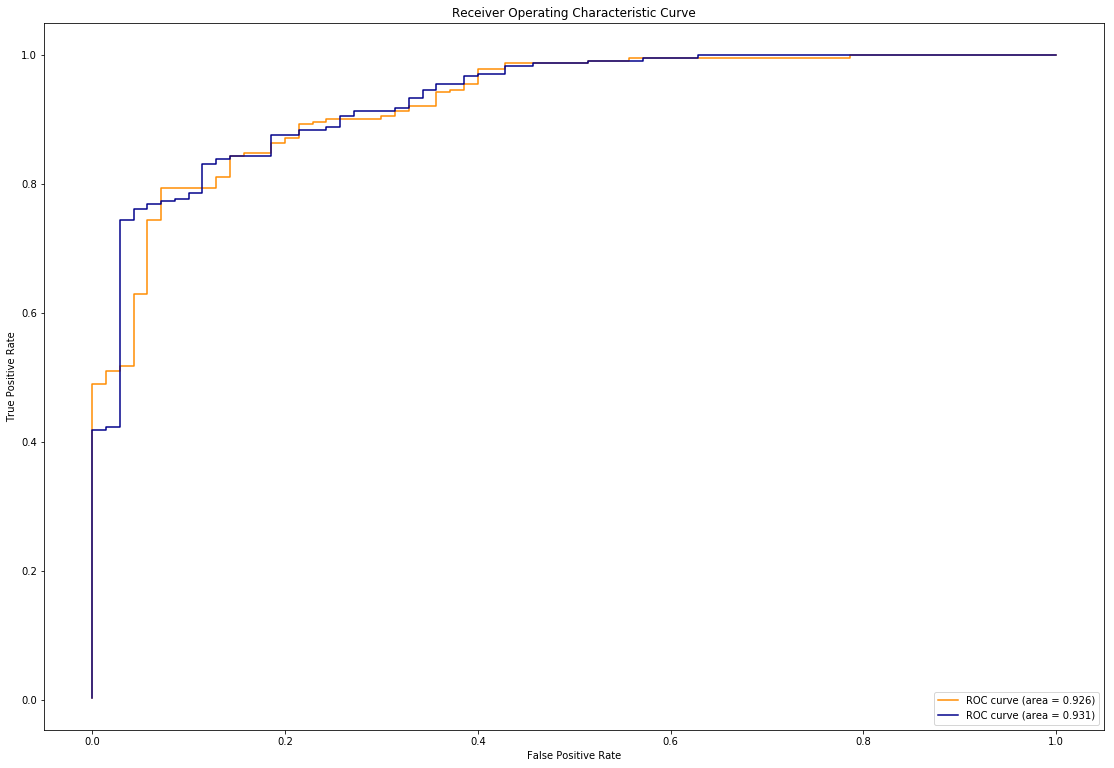

In [24]:
fprA, tprA, _ = metrics.roc_curve(Y_all[-313:], Y_predict_A)
plt.plot(fprA, tprA, color='darkorange', label='ROC curve (area = %0.3f)' % metrics.auc(fprA, tprA))

fprB, tprB, _ = metrics.roc_curve(Y_all[-313:], Y_predict_B)
plt.plot(fprB, tprB, color='darkblue', label='ROC curve (area = %0.3f)' % metrics.auc(fprB, tprB))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

We can also combine the two predictions, one simple way would be to take the average. This technique of combining predictions from several models is called **model ensembling**.

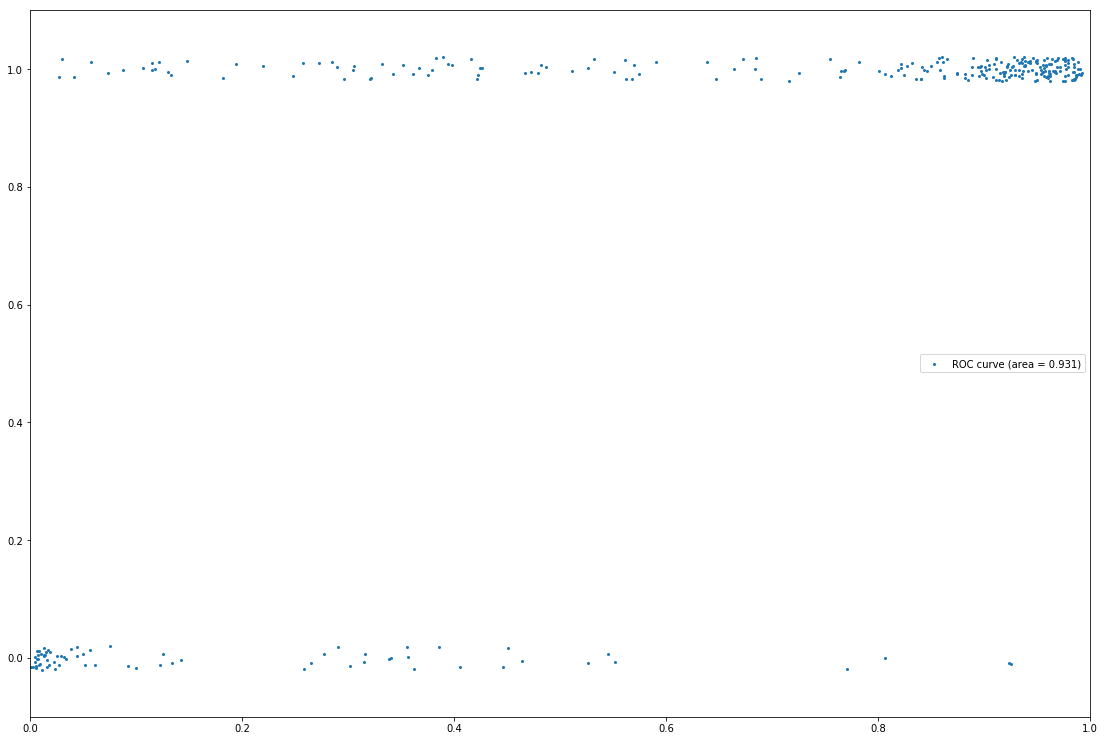

In [26]:
Y_predict_average = 0.5*(Y_predict_A + Y_predict_B)
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict_average)
plt.scatter(Y_predict_average, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

Observation: Interestingly, ensembling did not help increase the AUROC score at all!

What if we do a 40-60 blend?

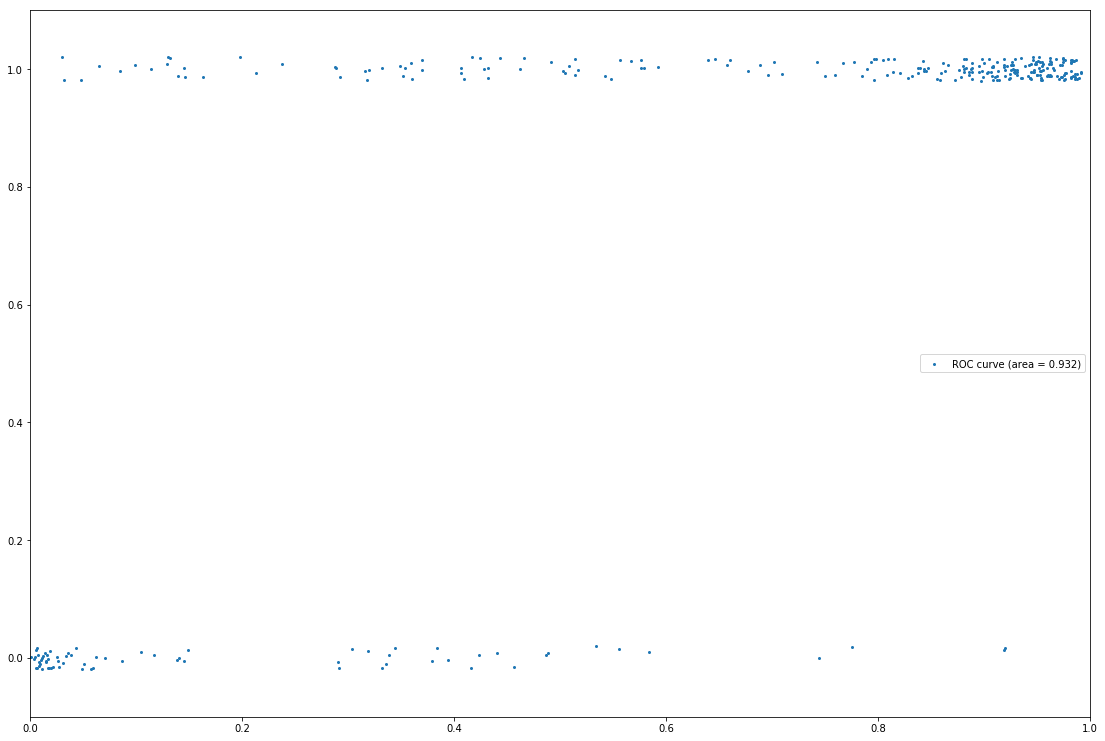

In [33]:
Y_predict_average = 0.4*Y_predict_A + 0.6*Y_predict_B
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict_average)
plt.scatter(Y_predict_average, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

Observation: The AUROC score increased by a tiny amount, nothing to write home about.

Ensembling is more powerful when we have more models and when their predictions are not highly correlated.

In [56]:
scan_range = np.arange(0.0, 1.0, 0.002)
auroc = np.zeros_like(scan_range)

for i in range(len(scan_range)):
    Y_predict_average = scan_range[i]*Y_predict_A + (1-scan_range[i])*Y_predict_B
    fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict_average)
    auroc[i] = metrics.auc(fpr, tpr)

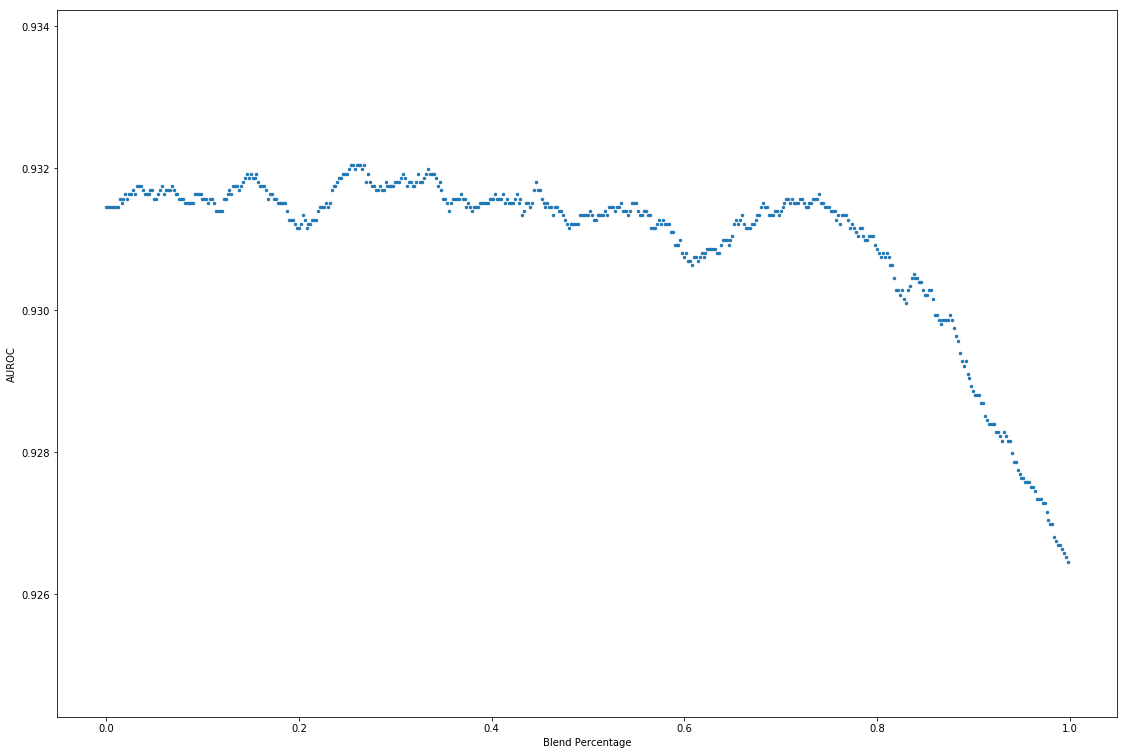

In [58]:
plt.scatter(scan_range, auroc, s=6, label='AUROC vs Blend Percentage');
plt.xlabel('Blend Percentage')
plt.ylabel('AUROC')